<a href="https://colab.research.google.com/github/Axion007/Git-Tutorial-DeployX/blob/main/Team_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import sklearn

print("Python executable:", sys.executable)
print("sklearn version:", sklearn.__version__)


Python executable: c:\Users\Anurag Tiwari\Downloads\credit-default-prediction\venv\Scripts\python.exe
sklearn version: 1.8.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


ModuleNotFoundError: No module named 'matplotlib'

**DATA COLLECTION:

In [ ]:
df = pd.read_csv("/content/UCI_Credit_Card.csv")

df = df.drop_duplicates()
df = df.dropna()

df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


**Class imbalance check**

In [ ]:
target = 'default.payment.next.month'


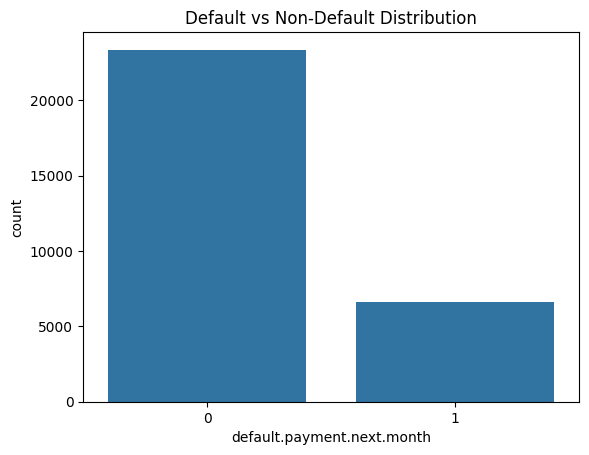

default.payment.next.month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


In [ ]:
sns.countplot(x=df[target])
plt.title("Default vs Non-Default Distribution")
plt.show()

print(df[target].value_counts(normalize=True))


Drop Id

In [ ]:
df = df.drop('ID', axis=1)


**Feature-Target Split / Normalisation**

In [ ]:
# Select features used in deployment
selected_features = ['LIMIT_BAL', 'AGE', 'PAY_0']

X = df[selected_features]
y = df[target]

**Train–Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


**Scaling**

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


**EDA**

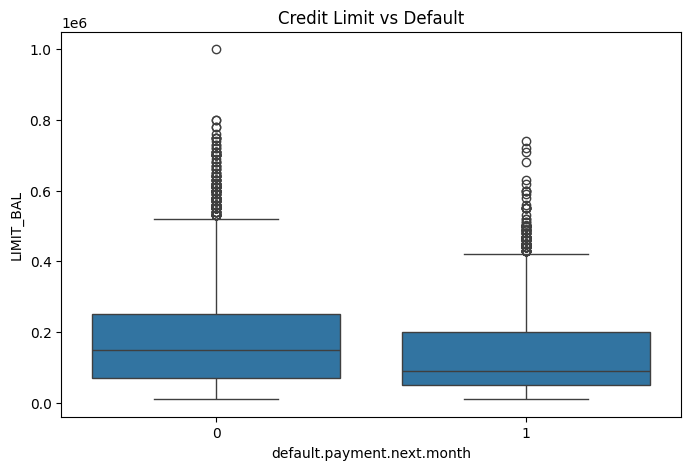

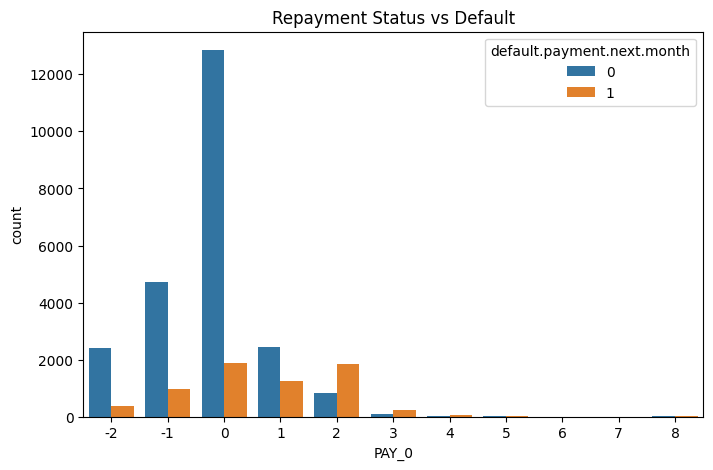

In [ ]:
# Default rate vs Credit Limit
plt.figure(figsize=(8,5))
sns.boxplot(x=target, y='LIMIT_BAL', data=df)
plt.title("Credit Limit vs Default")
plt.show()

# Default vs Repayment Status
plt.figure(figsize=(8,5))
sns.countplot(x='PAY_0', hue=target, data=df)
plt.title("Repayment Status vs Default")
plt.show()


**HEATMAP**

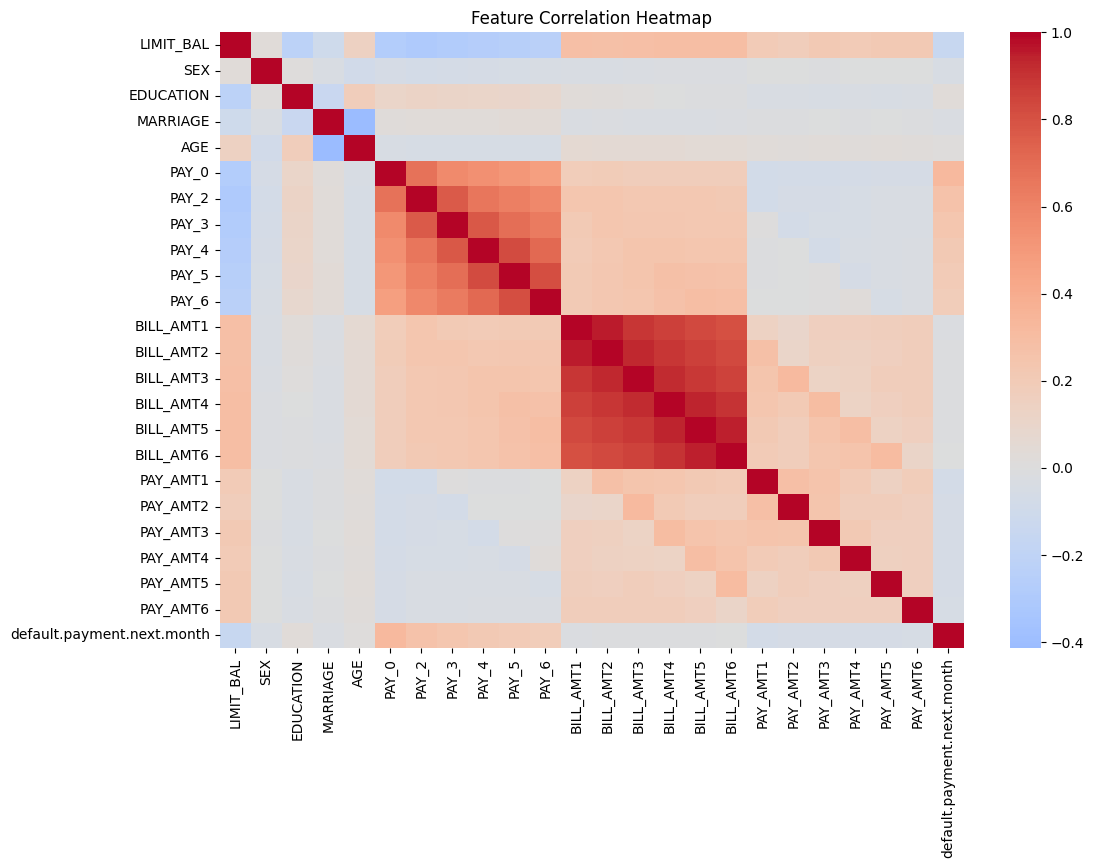

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


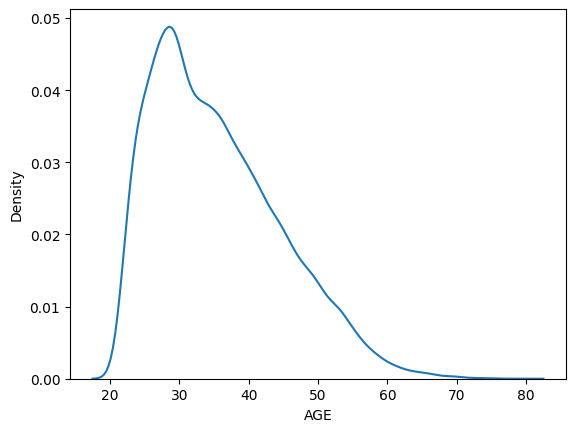

In [ ]:
sns.kdeplot(df['AGE'])
plt.show()


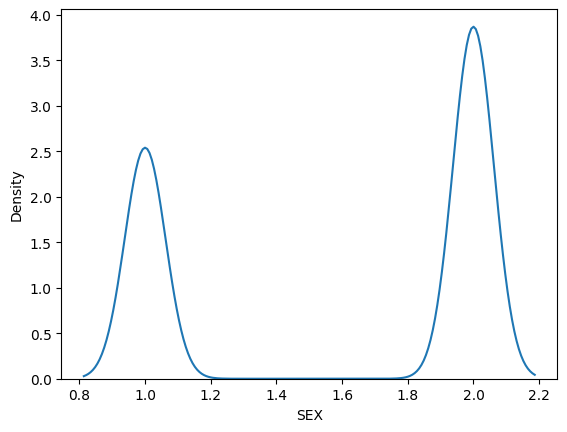

In [ ]:
sns.kdeplot(df['SEX'])
plt.show()

**Model Training**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)



**Evaluation**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

rf_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


[[4307  366]
 [ 881  446]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4673
           1       0.55      0.34      0.42      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.63      0.65      6000
weighted avg       0.77      0.79      0.77      6000



**HYPERPARAMETER TUNING**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_


**MODEL COMPARISON TABLE**

In [ ]:
from sklearn.metrics import f1_score, recall_score

models = {
    "Logistic Regression": lr_model,
    "Decision Tree": dt_model,
    "Random Forest": best_rf
}

results = []

for name, model in models.items():
    preds = model.predict(X_test)
    results.append({
        "Model": name,
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "Accuracy": accuracy_score(y_test, preds)
    })

pd.DataFrame(results)


,Model,Recall,F1,Accuracy
0,Logistic Regression,0.628485,0.459378,0.672833
1,Decision Tree,0.298417,0.387476,0.791333
2,Random Forest,0.513941,0.490471,0.763833


**Feature Importance**

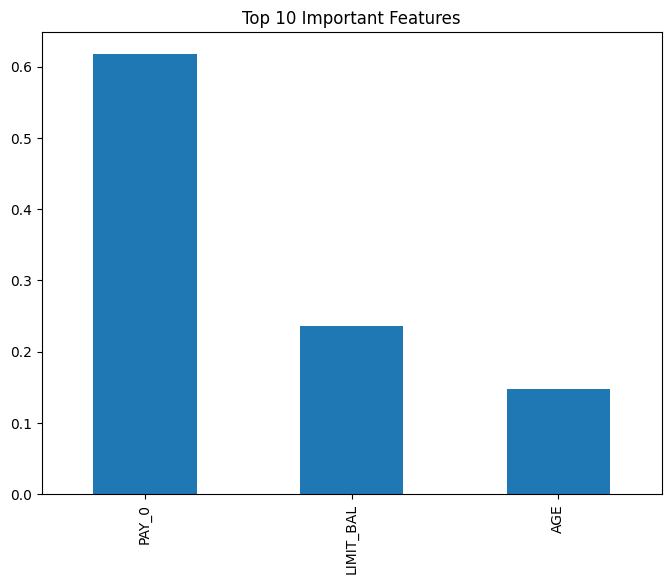

In [ ]:
importances = best_rf.feature_importances_
features = selected_features
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)


feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp.head(10).plot(kind='bar')
plt.title("Top 10 Important Features")
plt.show()


**Model Saving**

In [ ]:
import pickle
from pathlib import Path

Path("model").mkdir(exist_ok=True)

with open("model/credit_default_rf_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("model/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


Model saved successfully


-----------------------------------------------------

In [ ]:
!mkdir credit-default-prediction

mkdir: cannot create directory ‘credit-default-prediction’: File exists


In [ ]:
%cd credit-default-prediction


/content/credit-default-prediction/credit-default-prediction


In [ ]:
!mv /content/credit_default_rf_model.pkl .
!mv /content/scaler.pkl .


In [ ]:
!ls


credit_default_rf_model.pkl  requirements.txt  scaler.pkl  streamlit_app.py


**Streamlit_app.py**

In [ ]:
import streamlit as st
import pickle
import numpy as np

# -------------------------------
# Load Model & Scaler
# -------------------------------
with open("credit_default_rf_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# -------------------------------
# Page Config
# -------------------------------
st.set_page_config(
    page_title="Credit Default Prediction",
    page_icon="💳",
    layout="centered"
)

# -------------------------------
# App Header
# -------------------------------
st.title("💳 Credit Default Prediction System")
st.markdown(
    """
    This application predicts the **probability of loan default**
    using a machine learning model trained on historical credit data.
    """
)

st.divider()

# -------------------------------
# Input Section
# -------------------------------
st.subheader("Applicant Information")

col1, col2 = st.columns(2)

with col1:
    limit_bal = st.number_input(
        "Credit Limit (₹)",
        min_value=0.0,
        step=1000.0,
        help="Total approved credit limit for the applicant"
    )

with col2:
    age = st.number_input(
        "Age",
        min_value=18,
        max_value=100,
        help="Applicant age in years"
    )

pay_0 = st.selectbox(
    "Repayment Status (PAY_0)",
    options=list(range(-2, 9)),
    help="""
    -2 = No consumption
    -1 = Paid duly
     0 = Revolving credit
     1–8 = Payment delay (months)
    """
)

# -------------------------------
# Prediction
# -------------------------------
st.divider()

if st.button("🔍 Predict Credit Risk"):
    X = np.array([[limit_bal, age, pay_0]])
    X_scaled = scaler.transform(X)

    prediction = model.predict(X_scaled)[0]
    probability = model.predict_proba(X_scaled)[0][1]

    st.subheader("Prediction Result")

    st.metric(
        label="Default Probability",
        value=f"{probability:.2%}"
    )

    if probability >= 0.6:
        st.error("⚠️ High Credit Risk: Likely to Default")
        st.markdown(
            """
            **Recommendation:**
            - Consider rejecting the loan
            - Or apply stricter terms / higher interest
            """
        )
    else:
        st.success("✅ Low Credit Risk: Unlikely to Default")
        st.markdown(
            """
            **Recommendation:**
            - Applicant appears creditworthy
            - Loan approval can be considered
            """
        )

# -------------------------------
# Footer
# -------------------------------
st.divider()
st.caption("⚙️ ML Model: Random Forest | Evaluation Metric: Recall & F1-score")


Overwriting streamlit_app.py


**requirements.txt**

In [ ]:
%%writefile requirements.txt
streamlit
numpy
scikit-learn


Overwriting requirements.txt


In [ ]:
!ls


credit_default_rf_model.pkl  requirements.txt  scaler.pkl  streamlit_app.py


In [ ]:
!zip -r credit-default-prediction.zip \
    app.py \
    credit_default_rf_model.pkl \
    scaler.pkl \
    requirements.txt


	zip warning: name not matched: app.py
  adding: credit_default_rf_model.pkl (deflated 63%)
  adding: scaler.pkl (deflated 28%)
  adding: requirements.txt (stored 0%)
